# Force Free with planar symmetry 

## MP5

We solve the Force-Free equations using the MP5 (monotonicity preserving of order 5) method.

Force-Free: the variables are the magnetic field and the Poyting vector, $U = (S^i, B^i)$
\begin{eqnarray}
\dot{S^i} &=& -\partial_x(T^{xi}) = \partial_x(e \delta^{xi} - E^x E^i - B^x B^i) \\
\dot{B^i} &=& -\partial_x(v^x B^i - v^y B^i) 
\end{eqnarray}
Where, $e = \frac{1}{2}(E^2 + B^2) = \frac{1}{2}(\frac{S^2}{B^2}+B^2)$ y $v^i = \frac{S^i}{B^2}$. We can take $B^x$ to be constant (from $\nabla \cdot B=0$). Furthermore we need to initially impose $S \cdot B$ = 0$, and $v^2 < 1$.
Where $v^i = \frac{S^i}{B^2}$

In [2]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations

In [3]:
using Plots

We define the numerical parameters for the problem. The interval size, number of nodes, final time. 
Note that we fix the time interval so that to ensure the CFL condition would hold. Recall that that depends on the maximum propagation speed of the system. Finally we give some parameters to be passed to the equations.

In [4]:
L=1.
N=400 # number of space-points in the discretization
T=1.
dx = L/N
dt = 0.1 * dx
U=5 # number of fields
u0=zeros(N*U) # for the initial data U0=(Sx,Sy,By)
du=zeros(N*U) # for the rhs
x = zeros(N) # the coordinates
Bx = 1.
par_eq = (Bx, 0., 1.) #Bx, s, a some parameters to use on the equations

(1.0, 0.0, 1.0)

Next we include the utils needed for the methods. 

In [5]:
include("choques_utils.jl") # all functions needed 

kt (generic function with 1 method)

Here we compute the maximum propagation speed, this is needed to adjust the dissipation of the method. In this case the propagation speed of the highest mode is 1. 

In [6]:
function Speed_max(u, par_eq)
    #  Here we compute the maximal propagation speed of the equation, for the cases of real eigenvalues is the spectral radious of the 
    #  Jacobian (when the roots have imaginary values I guess it is the maximal real part of the eigenvalues).
    Bx, s, a = par_eq
    return 1.
end


Speed_max (generic function with 1 method)

Here we give the Flux function. Recall we are solving problems of the type, 
$$ u_t = F(u)_x$$

In [41]:
function Flux_x(u_l::Array{Float64,1}, par_eq)::Array{Float64,1}
    # this is the flux function
    Bx, s, a = par_eq
    Sx = u_l[1]
    Sy = u_l[2]
    Sz = u_l[3]
    By = u_l[4]
    Bz = u_l[5]
    
    B2 = Bx^2 + By^2 + Bz^2
    S2 = Sx^2 + Sy^2 + Sz^2
    e = 0.5 * (S2/B2 + B2)
    vx = Sx/B2
    vy = Sy/B2
    vz = Sz/B2
    Ex = -(vy * Bz - vz * By)
    Ey = -(vz * Bx - vx * Bz)
    Ez = -(vx * By - vy * Bx)
    #E2 = Ex^2 + Ey^2 + Ez^2
    f_l = zeros(U)
    #if S2 > 0.9*B2
    #else
    #    s = 0.
    #end
    
    f_l[1] = e - (Ex^2 + Bx^2) 
    f_l[2] = -(Ex*Ey + Bx*By) 
    f_l[3] = -(Ex*Ez + Bx*Bz)
    f_l[4] = vx*By - vy*Bx 
    f_l[5] = vx*Bz - vz*Bx

    return f_l
end
        

Flux_x (generic function with 1 method)

We increase the parameter tuple to include more parameters needed for the method.

In [42]:
par = (par_eq, 1. /dx, U, N, Flux_x, Speed_max) #

((1.0, 0.0, 1.0), 400.0, 5, 400, Flux_x, Speed_max)

The integration funcition is built from local generic functions.

In [43]:
function f(du,u,par,t)
    # this is the function that takes the time-integrator
    par_eq, h1, U, N, Flux_x, Speed_max = par

    for j in 1:N
        mp5(du,u,par,j)
    end
    return du[:]
end

f (generic function with 1 method)

Next we give the initial data. The solution is a big array of size $N \times U$, we transform it, whenever necesary, into a matrix array, whose columns are the different fields and the rows the different disctretization points. 

For convergence it is convenient to choose initial data which are smooth and which can be constructed out of pieces of polynomials.

Recall that for Force-Free the norm of the magnetic field must be smaller than the norm of the electric field, that means we need $S^2 < B^4$. That is, $v^2 < 1$. We also need that $S \cdot B = 0$

We start with an initial data where only the magnetic field is different from zero. $Bx=1$ and we put a $By$ component of compact support.

In [44]:
# the initial data
u0=zeros(N*U) # for the initial data U0=(Sx,Sy,By)
x0 = 0.4; x1 = 0.6

v0 = reshape(u0,(N,U))
for i in 1:N
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        v0[i,3] = 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                    #Sz
        v0[i,4] = -0.1 * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
        
    end
    v0[i,5] = 0.5 #Bz
    v0[i,1] = - (v0[i,4] * v0[i,2] + v0[i,5] * v0[i,3])/Bx 
end

#f(du,u0,par,t);

We try another initial data, it has the electric and magnetic field at $45^0$ to the propagation direction. And a factor of $\frac{E}{B} = \sqrt{1/2}$.

In [45]:
u0=zeros(N*U) # for the initial data U0=(Sx,Sy,By)
x0 = 0.4; x1 = 0.6

v0 = reshape(u0,(N,U))
for i in 1:N
    x[i] = dx*(i-1)
    Sx = 0
    Sy = 0
    Sz = Bx*Bx*sqrt(2)
    By = Bx
    Bz = 0
    if x[i] > x0 && x[i] < x1
        Sz = Sz + 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                    #Sz
        Sy = Sy - 0.1 * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
        
    end

    v0[i,1] = - (Sy*By + Sz*Bz)/Bx # Sx 
    v0[i,2] = Sy
    v0[i,3] = Sz
    v0[i,4] = By
    v0[i,5] = Bz
    
end

#f(du,u0,par,t);

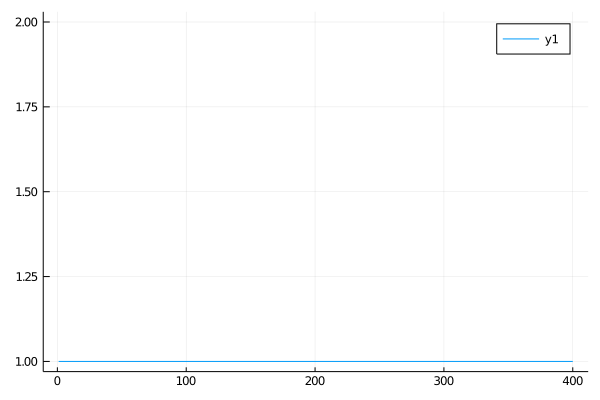

In [46]:
plot(v0[:,4])

Now we are in conditions of defining the problems and choose integrators and fix their behaviour. Here it is important to choose a stable integrator, namely one that has a stability region including some of the imaginary axis, and preferably an integrator that is total variation diminishing (TVD)

In [47]:
prob = ODEProblem(f,u0,(0.0,T),par);

In [48]:
sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*T); # This, I think, is a TVD method
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);

Once we have the solution we can analyze it. 

First we check the constraint: 

In [49]:
t = 0.01
function SB(t,sol,N,U)
    SSx = reshape(sol(t),(N,U))[:,1]
    SSy = reshape(sol(t),(N,U))[:,2]
    SSz = reshape(sol(t),(N,U))[:,3]
    BBy = reshape(sol(t),(N,U))[:,4]
    BBz = reshape(sol(t),(N,U))[:,5]
    BBx = ones(N)

    return (SSx .* BBx + SSy .* BBy + SSz .* BBz) #./sqrt.(SSx .* SSx + SSy .* SSy + SSz .* SSz)./sqrt.(BBx .* BBx + BBy .* BBy + BBz .* BBz)
end

SB (generic function with 1 method)

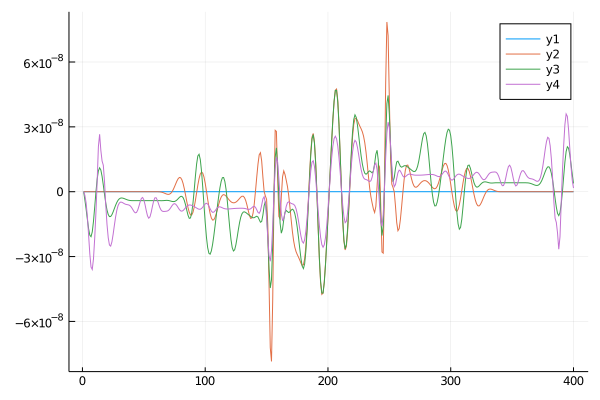

In [50]:
plot(SB(0,sol,N,U))
plot!(SB(T/4,sol,N,U))
plot!(SB(T/2,sol,N,U))
plot!(SB(T/1,sol,N,U))

In [51]:
sqrt(SB(T,sol,N,U)' * SB(T,sol,N,U))/N

6.066771587460779e-10

Now we look at the condition for the velocity: $v < 1$

In [52]:
function norm_v(t, sol, N)
    SSx = reshape(sol(t),(N,U))[:,1]
    SSy = reshape(sol(t),(N,U))[:,2]
    SSz = reshape(sol(t),(N,U))[:,3]
    BBy = reshape(sol(t),(N,U))[:,4]
    BBz = reshape(sol(t),(N,U))[:,5]
    BBx = ones(N)
    S2 = SSx .* SSx + SSy .* SSy + SSz .* SSz
    B2 = BBx .* BBx + BBy .* BBy + BBz .* BBz
    B4 = B2 .* B2
    v = sqrt.(S2./B4)
end
norm_v(0.01, sol, N);

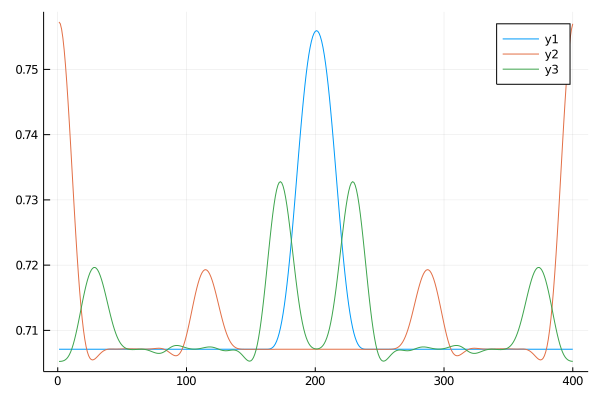

In [53]:
plot(norm_v(T*0., sol, N))
plot!(norm_v(T/2.1, sol, N))
plot!(norm_v(T/1.1, sol, N))

Now we plot $S^x$

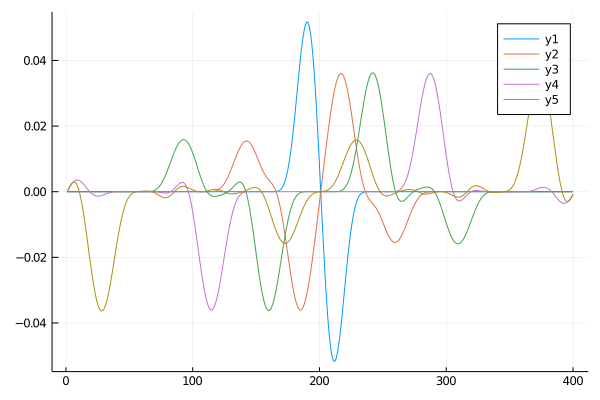

In [54]:
u = 1
plot(reshape(sol(0.),(N,U))[:,u])
plot!(reshape(sol(T/8),(N,U))[:,u])
plot!(reshape(sol(T/4),(N,U))[:,u])
plot!(reshape(sol(T/2.1),(N,U))[:,u])
plot!(reshape(sol(T/1.1),(N,U))[:,u])


$S^y$

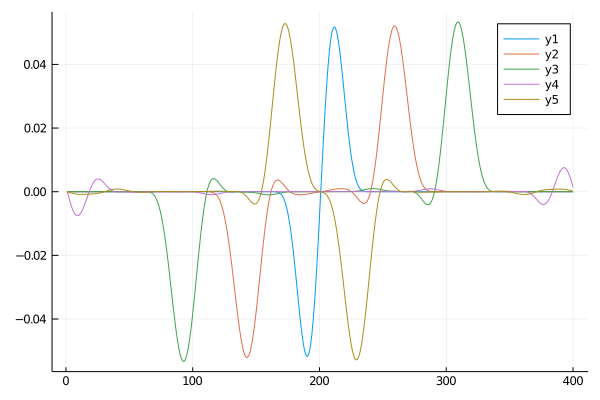

In [55]:
u = 2
plot(reshape(sol(0.),(N,U))[:,u])
plot!(reshape(sol(T/8),(N,U))[:,u])
plot!(reshape(sol(T/4),(N,U))[:,u])
plot!(reshape(sol(T/2.1),(N,U))[:,u])
plot!(reshape(sol(T/1.1),(N,U))[:,u])


$S^z$

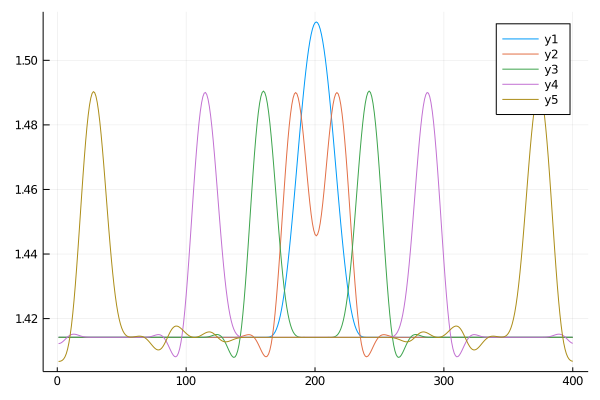

In [56]:
u = 3
plot(reshape(sol(0.),(N,U))[:,u])
plot!(reshape(sol(T/8),(N,U))[:,u])
plot!(reshape(sol(T/4),(N,U))[:,u])
plot!(reshape(sol(T/2.1),(N,U))[:,u])
plot!(reshape(sol(T/1.1),(N,U))[:,u])

$B^y$

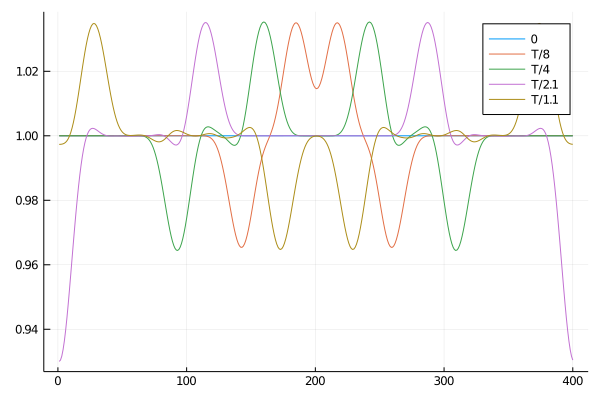

In [57]:
u = 4
plot(reshape(sol(0.),(N,U))[:,u],label="0")
plot!(reshape(sol(T/8),(N,U))[:,u],label="T/8")
plot!(reshape(sol(T/4),(N,U))[:,u],label="T/4")
plot!(reshape(sol(T/2.1),(N,U))[:,u],label="T/2.1")
plot!(reshape(sol(T/1.1),(N,U))[:,u],label="T/1.1")

$B^z$

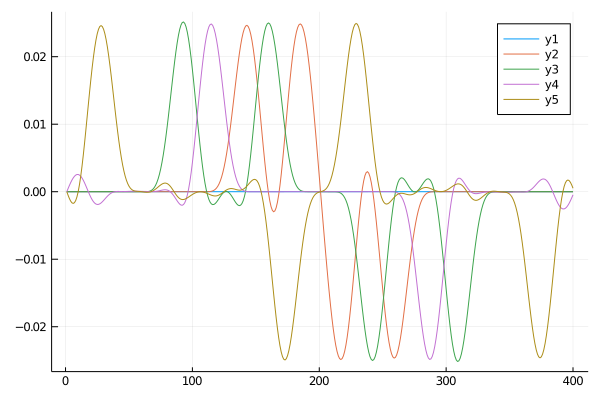

In [58]:
u = 5
plot(reshape(sol(0.),(N,U))[:,u])
plot!(reshape(sol(T/8),(N,U))[:,u])
plot!(reshape(sol(T/4),(N,U))[:,u])
plot!(reshape(sol(T/2.1),(N,U))[:,u])
plot!(reshape(sol(T/1.1),(N,U))[:,u])

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE2020/pde_private/ff_anim_fps20.gif
└ @ Plots /Users/reula/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Docencia/PDE2020/pde_private/ff_anim_fps20.gif")
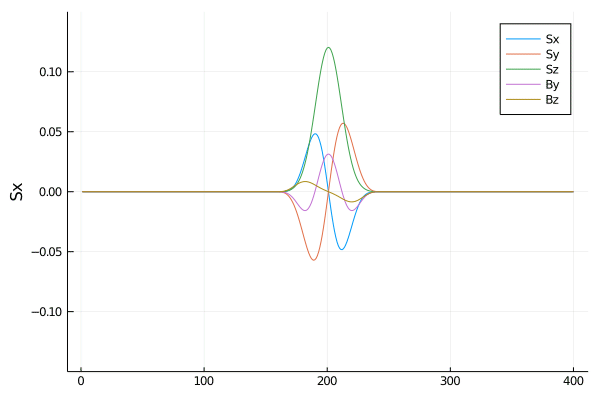

In [62]:
anim = @animate for i ∈ 1:100
    plot(reshape(sol(T*0.01*i),(N,U))[:,1],label="Sx", yaxis = ("Sx", (-0.15,0.15)))
    plot!(reshape(sol(T*0.01*i),(N,U))[:,2],label="Sy")
    plot!(reshape(sol(T*0.01*i),(N,U))[:,3].-Bx*Bx*sqrt(2),label="Sz")
    plot!(reshape(sol(T*0.01*i),(N,U))[:,4].-Bx,label="By")
    plot!(reshape(sol(T*0.01*i),(N,U))[:,5],label="Bz")
end

gif(anim, "ff_anim_fps20.gif", fps = 10)